In [131]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import logging
from itertools import combinations
from itertools import accumulate
import geopy.distance
import random
import math
import os
from matplotlib import pyplot as plt


logging.basicConfig(level=logging.DEBUG)

In [132]:
#directory
csv_directory = "C:/Users/matil/Politecnico Di Torino Studenti Dropbox/Matilde Carnevale/Politecnico/Computational Intelligence/Dati Lab2/"  
csv_files = [os.path.join(csv_directory, f) for f in os.listdir(csv_directory) if f.endswith('.csv')]

def load_and_distance_matrix(file_name):
    """Function to load the csv and to calculate the distance matrix
    """
    cities = pd.read_csv(file_name, header = None, names = ['City', 'lat', 'lon'])
    n_cities = len(cities)
    
    distance_matrix = np.zeros((n_cities, n_cities))
    for c1, c2 in combinations(cities.itertuples(), 2):
        distance_matrix[c1.Index, c2.Index] = distance_matrix[c2.Index, c1.Index] = geopy.distance.geodesic(
            (c1.lat, c1.lon), (c2.lat, c2.lon)
        ).km
        
    city_names = np.array(cities['City'])
    
    return distance_matrix, city_names, n_cities

In [133]:
def calculate_total_distance(path, dist):
    """Function to calculate the total distance of a path
    """
    total_distance = 0 
    
    for i in range(len(path)):
        total_distance += dist[path[i], path[(i+1) % len(path)]]
        
    return total_distance

In [134]:
def plot_cost(history, country_name):
    """Function to plot the history of the costs."""
    plt.figure(figsize=(14, 8))
    plt.plot(
        range(len(history)),
        list(accumulate(history, min)),
        color="red",
    ) 
    plt.scatter(range(len(history)), history, marker=".")
    plt.title(f"Cost History for {country_name}")
    plt.xlabel("Generation")
    plt.ylabel("Cost")

# Greedy alghorithm - Nearest Neighbor

In [137]:
def nearest_neighbor(dist, start_city, n_cities):
    """Function to generate an approximate TSP path using the nearest neighbor heuristic.
    """
    visited = np.full(n_cities, False)
    path = [int(start_city)]
    visited[start_city] = True
    total_distance = 0

    while len(path) < n_cities:
        last_city = path[-1] # last city visited
        
        # Find the nearest unvisited city to the last city
        closest_city = np.argmin([dist[last_city, j] if not visited[j] else np.inf for j in range(n_cities)])
        path.append(int(closest_city))
        
        # Mark the closest city as visited
        visited[closest_city] = True

    total_distance = calculate_total_distance(path, dist)  

    return path, total_distance


def best_path_with_NN(dist, n_cities, city_names):
    """ Finds the best TSP path starting from each city, using the nearest neighbor heuristic.
    """
    # Initialization
    best_distance = float('inf')
    best_path = None
    
    # Loop through each city as a potential starting point
    for start_city in range(n_cities):
        
        # Get path and total distance for the current starting city using nearest neighbor
        path, total_distance = nearest_neighbor(dist, start_city, n_cities)
        
        if total_distance < best_distance:
            best_distance = total_distance
            best_path = path
        
    #for i in range(len(best_path)-1):
        #print(f"step: {city_names[best_path[i]]} -> {city_names[best_path[i+1]]} ({dist[best_path[i],best_path[i+1]]:.2f}km)")
    
    return best_path, best_distance

In [139]:
# Loops through multiple CSV files to calculate the shortest TSP path

for file_name in csv_files:

    country_name = os.path.splitext(os.path.basename(file_name))[0]
    
    distance_matrix, city_names, n_cities = load_and_distance_matrix(file_name)
    dist = distance_matrix.copy()
    
    best_path, best_distance = best_path_with_NN(dist, n_cities, city_names)
    
    print(f"Result obtained for {country_name}: total length of the best path is {best_distance:.2f} km")
    print("\n" + "-"*50 + "\n")
    

Result obtained for china: total length of the best path is 62116.04 km

--------------------------------------------------

Result obtained for italy: total length of the best path is 4436.03 km

--------------------------------------------------

Result obtained for russia: total length of the best path is 40051.59 km

--------------------------------------------------

Result obtained for us: total length of the best path is 46244.33 km

--------------------------------------------------

Result obtained for vanuatu: total length of the best path is 1475.53 km

--------------------------------------------------



# Simulated Annealing with inver over crossover

In [140]:
# Initial parameters
population_size = 100
generations = 500
initial_temp = 500
alpha = 0.99

In [141]:
def create_population(n_cities, population_size):
    """Function to create initial population
    """
    population = []
    
    for _ in range(population_size):
        # Create a random path visiting each city exactly once
        path = random.sample(range(n_cities), n_cities)
        population.append(path)
        
    return population

def find_initial_best_solution(population, dist):
    """Function to find the best solution from the initial population based on total distance
    """
    best_path = None
    best_cost = float('inf')
    
    for path in population:
        cost = calculate_total_distance(path, dist)  
        if cost < best_cost:  
            best_cost, best_path = cost, path
    
    return best_path, best_cost


def tournament_selection(population, dist, tournament_size):
    """Function to select two parents from the population using tournament selection method
    """
    # Randomly select a subset of individuals from the population for the tournament
    tournament = random.sample(population, tournament_size)
    tournament_cost = [(individual, calculate_total_distance(individual, dist)) for individual in tournament]
    # Sort the tournament participants by their cost
    tournament_cost.sort(key=lambda x: x[1]) 
    
    # The best two individual
    p1 = tournament_cost[0][0]
    p2 = tournament_cost[1][0]
    
    return p1, p2


def crossover_random(p1, p2):
    """Crossover process between two parent routes, taking half of the cities from each.
        This method improves the initial exploration phase.
    """
    
    len_p1 = len(p1)
    o = [None] * len_p1
    
    # Randomly select half of the indices from parent1
    selected_indices = random.sample(range(len_p1), len_p1 // 2)
    for i in selected_indices:
        o[i] = p1[i]

    # Fill the remaining empty positions in the offspring with cities from parent2
    pos = 0 
    for i in range(len_p1):
        if o[i] is None: 
            # Skip cities already included
            while p2[pos] in o:
                pos += 1
            # Insert the city from parent2 into the empty position
            o[i] = p2[pos]
            pos += 1
    
    return o


def inver_over_crossover(p1, p2):
    """Inver over Crossover function
    """
    
    # Randomly select a city from the first parent path
    random_city_in_p1 = random.choice(p1)
    index_in_p1 = p1.index(random_city_in_p1)
    index_in_p2 = p2.index(random_city_in_p1)
    
    # Find the neighboring city in the second parent path
    neighbor = p2[(index_in_p2+1) % len(p2)] 
    
    # Create a copy of the first parent path and insert the neighbor after the selected city  
    # In this way, I'll have a path with one extra element. I will later remove the element that was already present before inserting its duplicate.
    p1_copy = p1.copy()
    p1_copy.insert((index_in_p1+1) % len(p1_copy), neighbor)
    o = []
        
    for i in range(len(p1_copy)):
        # If the current city is not the neighbor, add it to the offspring
        if p1_copy[i % len(p1_copy)] != neighbor:
            o.append(p1_copy[i])
        else:
            # If the element is equal to the neighbor and the selected city from parent 1 is before it, then it should be kept.
            if p1_copy[(i-1) % len(p1_copy)] == random_city_in_p1:
                index_true = i
                o.append(p1_copy[i])
                    
            else: 
                index_false = i
                o.append(p1_copy[i])
                
    o[index_true+1:index_false] = o[index_true+1:index_false][::-1]
    del o[index_false]
        
    return o

In [142]:
def simulated_annealing_with_crossover(num_cities, city_names, population_size, initial_temp, alpha, dist, generations):
    """Performs simulated annealing with crossover
    
    In the initial iterations, the crossover_random function is used to promotes exploration. 
    Afterward, the inver_over_crossover function is used to refine the search for better solutions.
    """
    population = create_population(num_cities, population_size)
    best_path, best_cost = find_initial_best_solution(population, dist)
    history = []
                
    temperature = initial_temp
    
    for i in range(generations):
        
        offspring_population = []
        
        if i < (generations/2):
            while len(offspring_population) < population_size:
                p1, p2 = tournament_selection(population, dist, tournament_size = 10)
                offspring = crossover_random(p1, p2)
                offspring_population.append(offspring) # Add offspring to the new population
        
        else:
            while len(offspring_population) < population_size:
                p1, p2 = tournament_selection(population, dist, population_size)
                offspring = inver_over_crossover(p1, p2)
                offspring_population.append(offspring)
        
        population = offspring_population # Update the population with new offspring
        
        for path in population:
            new_cost = calculate_total_distance(path, dist) 
           
           # Accept worse path with certain probability
            if new_cost <= best_cost:
                best_cost, best_path = new_cost, path
            else: 
                if random.uniform(0, 1) <= math.exp(-float(new_cost - best_cost) / float(temperature)):
                    best_cost, best_path = new_cost, path
                    
        history.append(best_cost)
        
        # Decrease the temperature
        temperature *= alpha
        
    #for i in range(len(best_path)-1):
    #    print(f"step: {city_names[best_path[i]]} -> {city_names[best_path[i+1]]} ({dist[best_path[i],best_path[i+1]]:.2f}km)")
    
    return best_path, best_cost, history

Result obtained for china: total length of the best path is: 564679.80 km

--------------------------------------------------

Result obtained for italy: total length of the best path is: 6054.71 km

--------------------------------------------------

Result obtained for russia: total length of the best path is: 110094.25 km

--------------------------------------------------

Result obtained for us: total length of the best path is: 192757.91 km

--------------------------------------------------

Result obtained for vanuatu: total length of the best path is: 1345.54 km

--------------------------------------------------



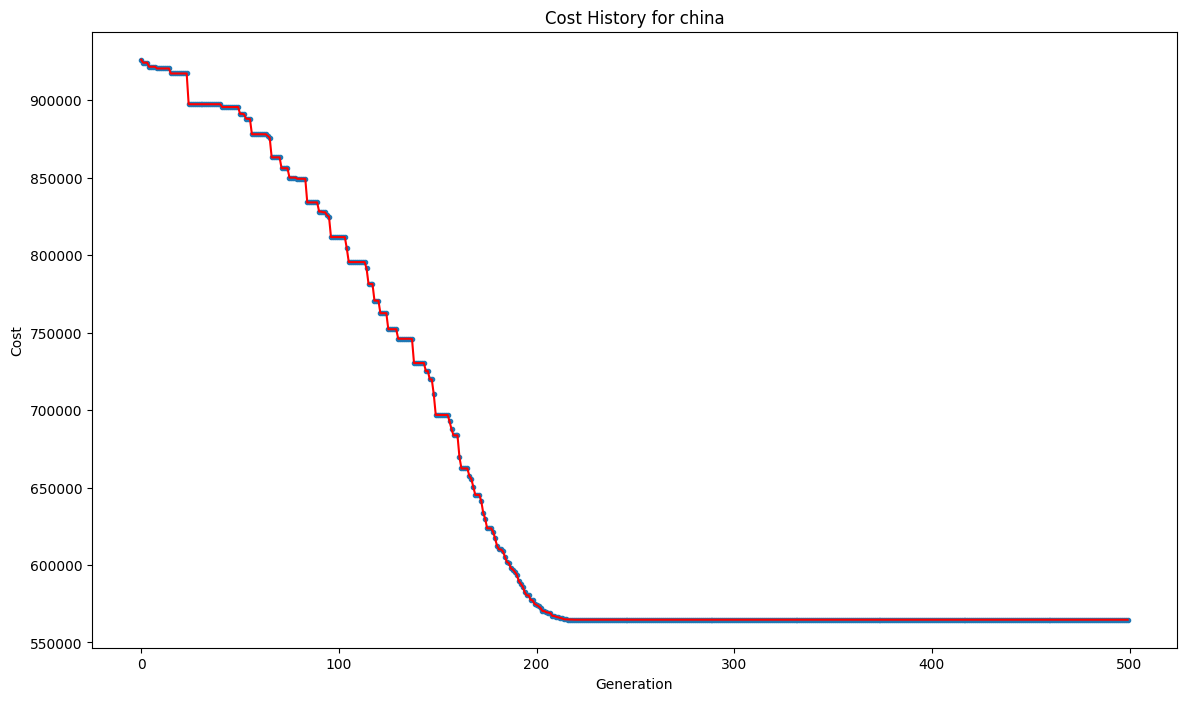

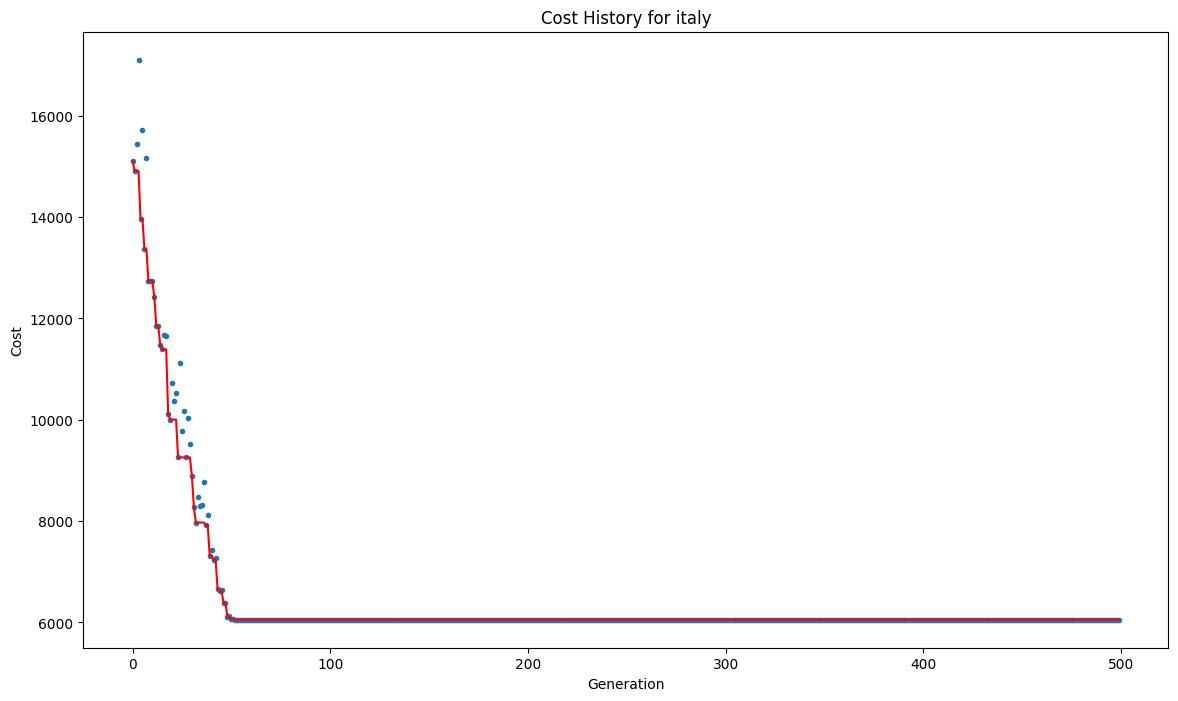

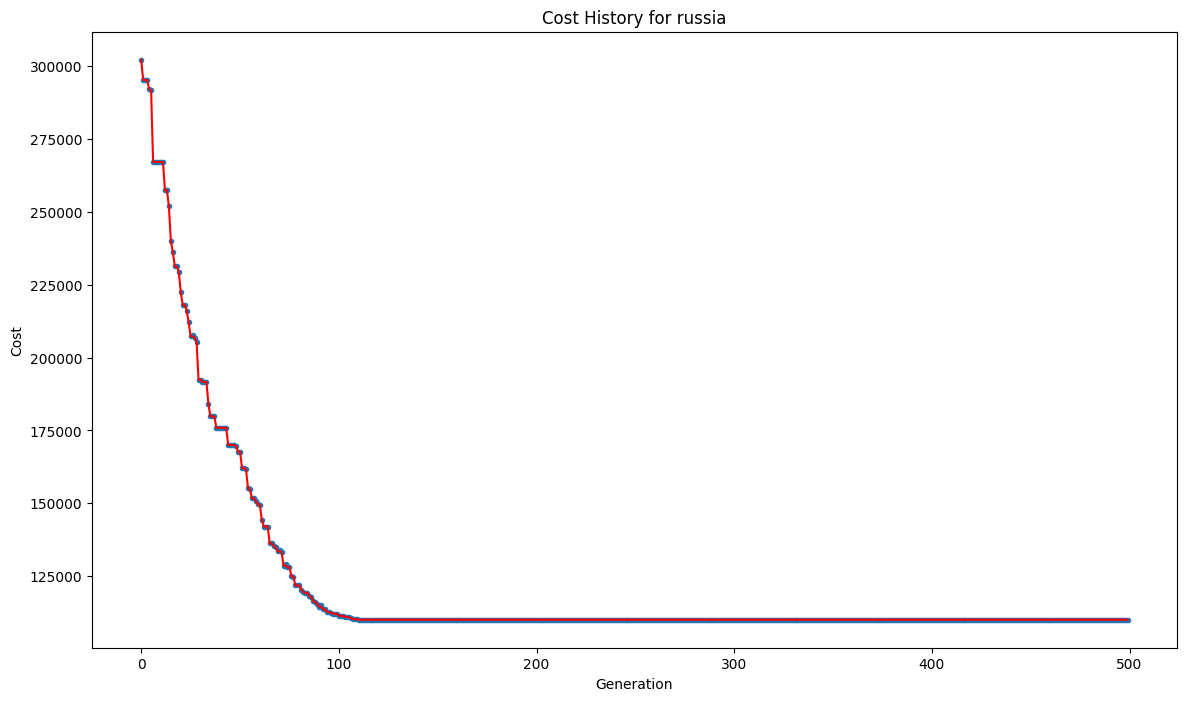

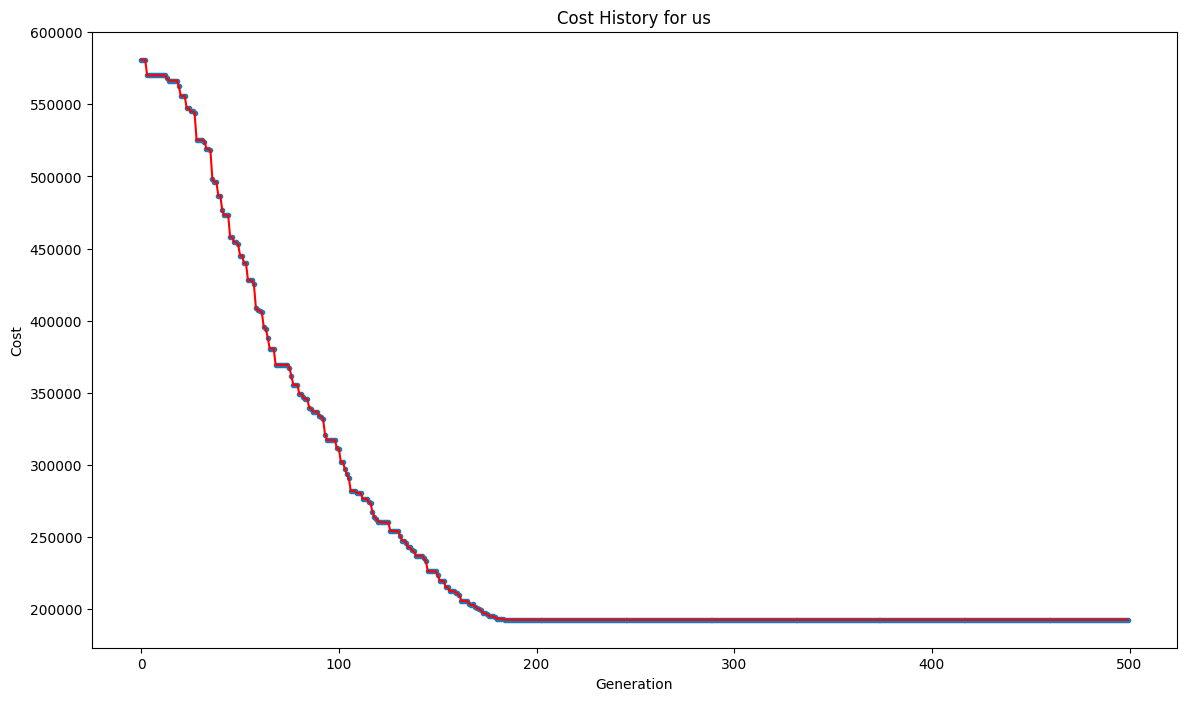

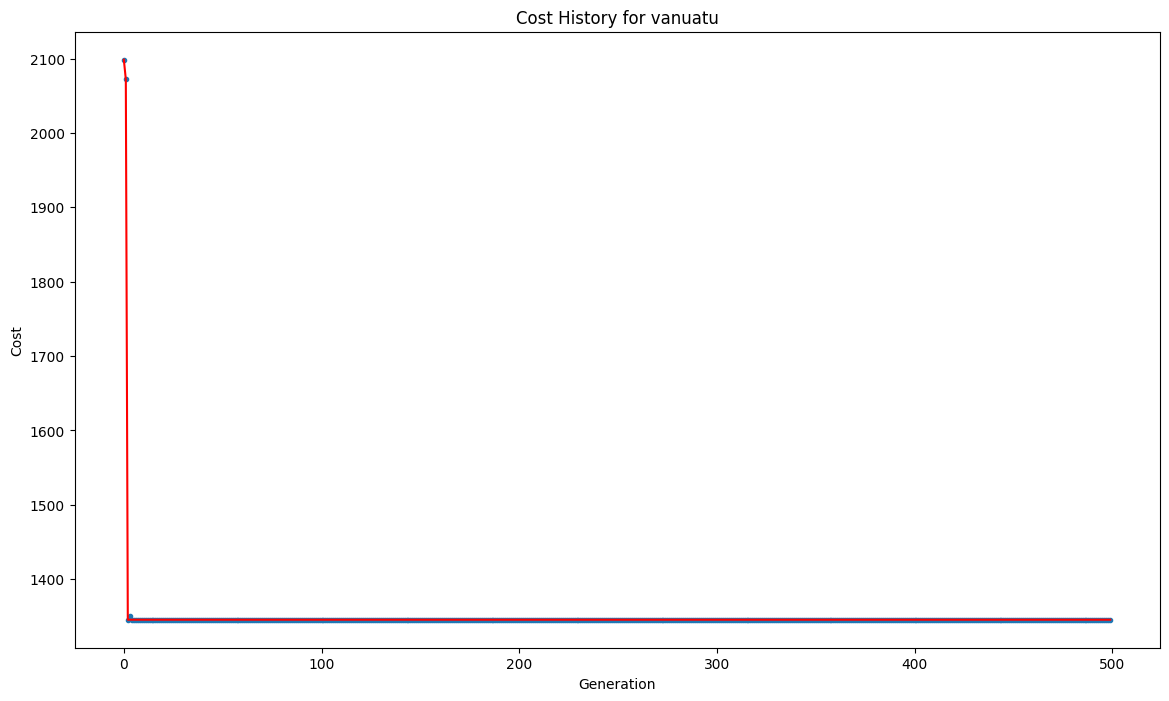

In [143]:
for file_name in csv_files:
    
    country_name = os.path.splitext(os.path.basename(file_name))[0]
    
    dist, city_names, n_cities = load_and_distance_matrix(file_name)
    
    best_path, best_distance, history =  simulated_annealing_with_crossover(n_cities, city_names, population_size, initial_temp, alpha, dist, generations)
    
    print(f"Result obtained for {country_name}: total length of the best path is: {best_distance:.2f} km")
    print("\n" + "-"*50 + "\n")
    
    plot_cost(history, country_name)